In [4]:
import numpy as np
import theano, theano.tensor as T
import theano_ext as TX
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
%matplotlib inline

In [2]:
x,y = T.scalars('x', 'y')
length_scale = 0.25
k = T.exp(-(x-y)**2 / (2*length_scale**2))
#k = T.exp(-2*T.sin((x-y)/2.)**2 / length_scale**2)
grad_x = TX.operators.Derivative(x)
grad_y = TX.operators.Derivative(y)

A = grad_x * grad_x
Abar = grad_y * grad_y
B = Bbar = TX.operators.Identity()

X = np.linspace(0,1,11)
X_interior = X[1:-1]
X_boundary = X[[0,-1]]

In [3]:
def pairwise_apply(fun, A, B):
    a, b = np.meshgrid(A, B, indexing='ij')
    res = np.vectorize(fun)(a.ravel(),b.ravel())
    return res.reshape(a.shape)

def kfun(k):
    fun = np.vectorize(theano.function([x,y], k))
    return lambda x, y: pairwise_apply(fun, x, y)

In [4]:
k_eval = kfun(k)
A_k = kfun(A*k)
B_k = kfun(B*k)
Abar_k = kfun(Abar*k)
Bbar_k = kfun(Bbar*k)
AAbar_k = kfun(A*Abar*k)
ABbar_k = kfun(A*Bbar*k)
BAbar_k = kfun(B*Abar*k)
BBbar_k = kfun(B*Bbar*k)
Lbar = lambda x: np.c_[Abar_k(x,X_interior), Bbar_k(x,X_boundary)].T
L = lambda x: np.c_[A_k(x,X_interior), B_k(x,X_boundary)].T
LLbar = np.r_[
    np.c_[AAbar_k(X_interior,X_interior), ABbar_k(X_interior,X_boundary)], 
    np.c_[BAbar_k(X_boundary,X_interior), BBbar_k(X_boundary,X_boundary)]
]
LLbar_inv = np.linalg.inv(LLbar)

In [5]:
g = np.concatenate([np.sin(2*np.pi*X_interior), [0,0]])

In [6]:
test_points = np.linspace(0,1,100)
g = g.reshape((g.shape[0],1))
test_points = test_points.reshape((test_points.shape[0],1))
mu = Lbar(test_points).T.dot(LLbar_inv).dot(g)
Sigma = k_eval(test_points, test_points) - Lbar(test_points).T.dot(LLbar_inv).dot(L(test_points))

<matplotlib.colorbar.Colorbar instance at 0x115e7e3b0>

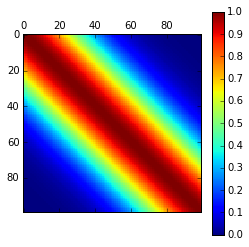

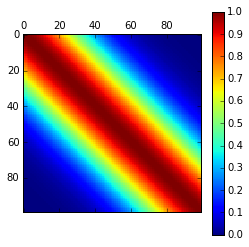

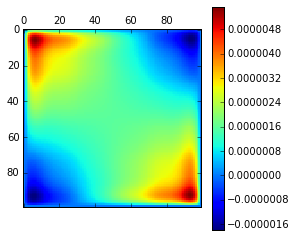

In [7]:
plt.colorbar(plt.matshow(k_eval(test_points, test_points)))
plt.colorbar(plt.matshow(Lbar(test_points).T.dot(LLbar_inv).dot(L(test_points))))
plt.colorbar(plt.matshow(Sigma))

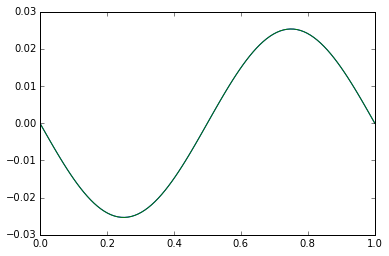

In [8]:
plt.plot(test_points, mu)
plt.plot(test_points, -np.sin(2*np.pi*test_points) / (4*np.pi**2))

In [9]:
samps = np.random.multivariate_normal(mu.ravel(), Sigma, 10).T

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


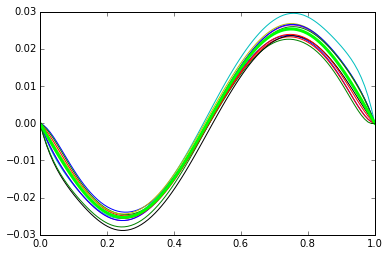

In [10]:
plt.plot(test_points, samps);
plt.plot(test_points, mu, c='lime', linewidth=3)